In [4]:
from PIL import Image
from numpy import asarray
import os
import sklearn.model_selection as ms

In [5]:
classes_paths = ["data_classes/Glioma", "data_classes/Meningioma", "data_classes/Pituitary"]

classes = []

In [6]:
for name in os.listdir("data_classes"):
    classes.append(name)

x, y = [], []
for idx, dire in enumerate(classes_paths):
    for filename in os.listdir(dire):
        if os.path.isfile(os.path.join(dire, filename)):
            img = Image.open(os.path.join(dire, filename)).convert('RGB')
            img = img.resize((224, 224))
            data = asarray(img)
            x.append(data)
            y.append(idx)
data_array = [x, y]

In [7]:
x_train, x_test, y_train, y_test = ms.train_test_split(data_array[0], data_array[1], test_size=0.2, shuffle=True)
print(f"Total training examples: {len(x_train)}")
print(f"Total training examples: {len(y_train)}")
print(f"Total test examples: {len(x_test)}")
print(f"Total test examples: {len(y_test)}")

print(len(x_train))

Total training examples: 2451
Total training examples: 2451
Total test examples: 613
Total test examples: 613
2451


In [8]:
%%capture

import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

vgg_model = VGG16(weights='imagenet', include_top=False)
all_features = []

for image_array in x_train:
    preprocessed_image = preprocess_input(image_array)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    features = vgg_model.predict(preprocessed_image)
    all_features.append(features)

In [9]:
all_features = np.concatenate(all_features, axis=0)

In [10]:
print(len(all_features))

2451


In [11]:
num_samples, height, width, num_features = all_features.shape
d2_train_dataset = all_features.reshape(num_samples, height * width * num_features)

In [12]:
from sklearn.cluster import AgglomerativeClustering

num_clusters = 3

agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglomerative.fit_predict(d2_train_dataset)

In [13]:
# from sklearn.cluster import KMeans
#
# num_clusters = 3
#
# kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
# clusters = kmeans.fit_predict(d2_train_dataset)

Real labels[0, 1, 2, 1, 0]
Real labels[2, 1, 1, 0, 0]
Real labels[2, 0, 0, 0, 2]


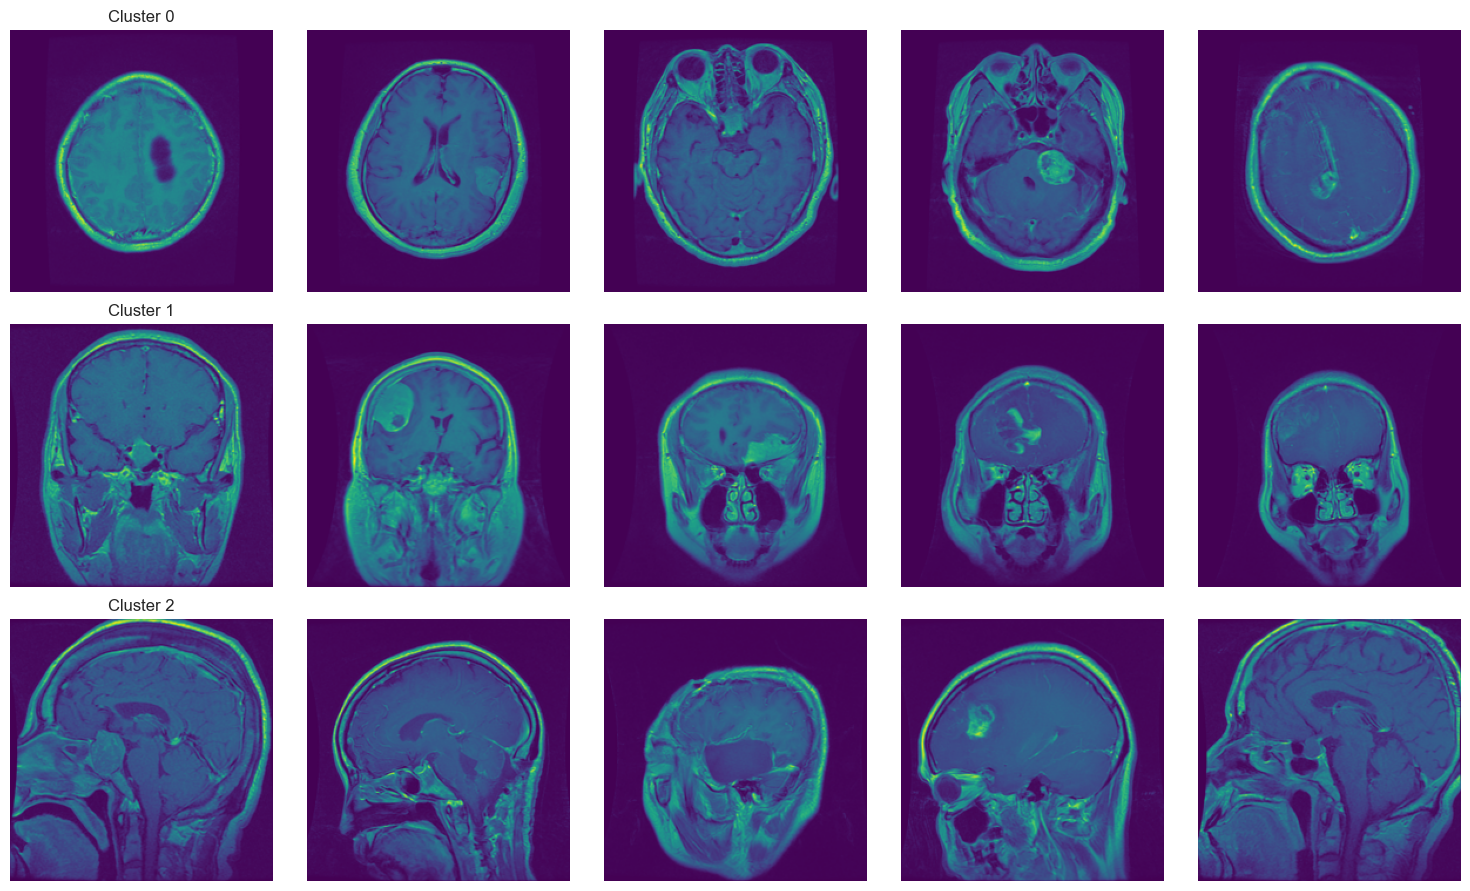

In [14]:
import matplotlib.pyplot as plt
import random

# Assuming you have the 'clusters' variable containing the cluster assignments
# Assuming you have the 'image_list' variable containing the original images

number_of_images = 5

fig, axs = plt.subplots(num_clusters, number_of_images, figsize=(15, num_clusters*3))

# Iterate over each cluster
for cluster_id in range(num_clusters):
    real_labels = []
    # Get the indices of images belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Randomly select five images from the cluster
    random_indices = random.sample(list(cluster_indices), number_of_images)

    # Iterate over the selected images
    for i, image_index in enumerate(random_indices):
        # Get the corresponding image array
        image_array = x_train[image_index]
        real_labels.append(y_train[image_index]) # DODAJ PRAWDZIWĄ LABELKE ABY SPRAWDZIĆ JAKOŚĆ GRUPOWANIA


        # Plot the image in the corresponding subplot
        ax = axs[cluster_id, i]
        ax.imshow(image_array)
        ax.axis('off')

    # Set the title for the cluster subplot
    axs[cluster_id, 0].set_title(f'Cluster {cluster_id}')
    print(f"Real labels{real_labels}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



In [15]:
clusters_reallabels = [[], [], []]

for cluster_id in range(num_clusters):
    real_labels = []
    # Get the indices of images belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    for x in cluster_indices:
        clusters_reallabels[cluster_id].append(y_train[x])

counts = [{"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}]
for x in range(len(clusters_reallabels)):
    for _ in clusters_reallabels[x]:
        counts[x][str(_)] += 1

print(counts)



[{'0': 400, '1': 171, '2': 225}, {'0': 402, '1': 191, '2': 253}, {'0': 337, '1': 224, '2': 248}]


In [16]:
def custom_cluster_accuracy(counts, n_classes):

    percentages = []
    for x in range(n_classes):
        percentages.append([])

    for idx, x in enumerate(percentages):
        suma = 0
        for s in range(n_classes):
            suma += counts[idx][str(s)]
        for i in range(n_classes):
             percentages[idx].append(counts[idx][str(i)] / suma)

    fi = n_classes*(1-1/n_classes+(n_classes-1)*1/n_classes)
    loss = fi

    for x in percentages:
        for i in x:
            loss -= abs(1/n_classes - i)

    print(f"Custom cluster accuracy 0-1: {round(1-loss/fi, 5)}")

In [17]:
custom_cluster_accuracy(counts, len(classes))

Custom cluster accuracy 0-1: 0.19713
